In [24]:

import torch
from torch.utils.data import DataLoader
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
from random import uniform

import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})


In [25]:
TRAIN_DATA_COUNT = 1024
theta = np.array([uniform(0, 2 * np.pi) for _ in range(TRAIN_DATA_COUNT)]) # np.linspace(0, 2 * np.pi, 100)


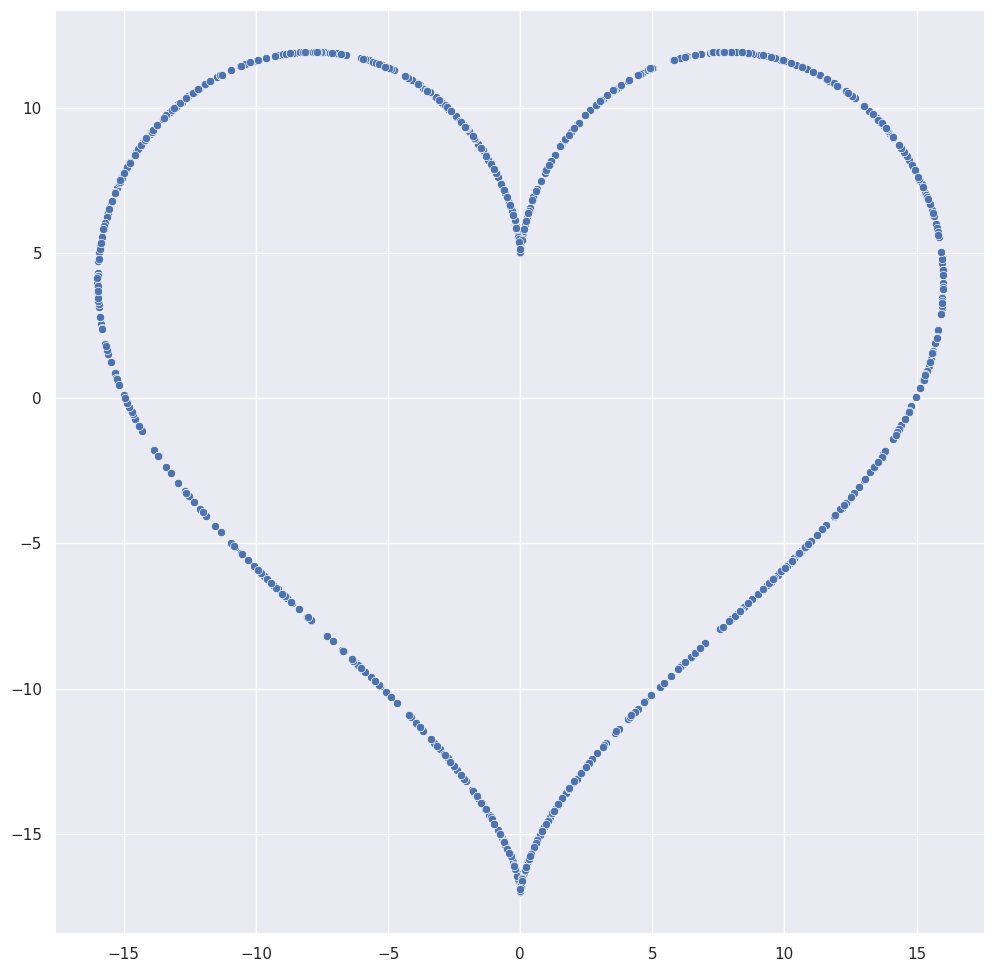

In [26]:

x = 16 * ( np.sin(theta) ** 3 )
y = 13 * np.cos(theta) - 5 * np.cos(2*theta) - 2 * np.cos(3*theta) - np.cos(4*theta)
sns.scatterplot(x=x, y=y)
plt.savefig('scatter_plot.png')

In [27]:

train_data = torch.Tensor(np.stack((x, y), axis=1))

train_labels = torch.zeros(TRAIN_DATA_COUNT)
train_set = [
    (train_data[i], train_labels[i]) for i in range(TRAIN_DATA_COUNT)
]

In [28]:

BATCH_SIZE = 64
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True
)


In [29]:

discriminator = nn.Sequential(
    nn.Linear(2, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)


generator = nn.Sequential(
    nn.Linear(2, 128),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(128),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512),
    nn.Linear(512, 2)
)


In [30]:
!mkdir train_progress

mkdir: cannot create directory ‘train_progress’: File exists


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

LR = 0.001
NUM_EPOCHS = 2000

loss_function = nn.BCELoss()
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LR)
optimizer_generator = optim.Adam(generator.parameters(), lr=LR)


for epoch in range(NUM_EPOCHS):
    for n, (real_samples, _) in enumerate(train_loader):
        real_samples_labels = torch.ones((BATCH_SIZE, 1))
        latent_space_samples = torch.randn((BATCH_SIZE, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((BATCH_SIZE, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        if epoch % 2 == 0:
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

        if epoch % 2 == 1:
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

            if epoch % 100 == 0:
              print(epoch)
              print(f"Epoch {epoch}, Discriminator Loss {loss_discriminator}")
              print(f"Epoch {epoch}, Generator Loss {loss_generator}")
              with torch.no_grad():
                  latent_space_samples = torch.randn(1000, 2)
                  generated_samples = generator(latent_space_samples).detach()
              plt.figure()
              plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
              plt.xlim((-20, 20))
              plt.ylim((-20, 15))
              plt.text(10, 15, f"Epoch {epoch}")
              plt.savefig(f"train_progress/image{str(epoch).zfill(3)}.jpg")
              plt.close()


Text(10, 15, 'Epoch 1999')

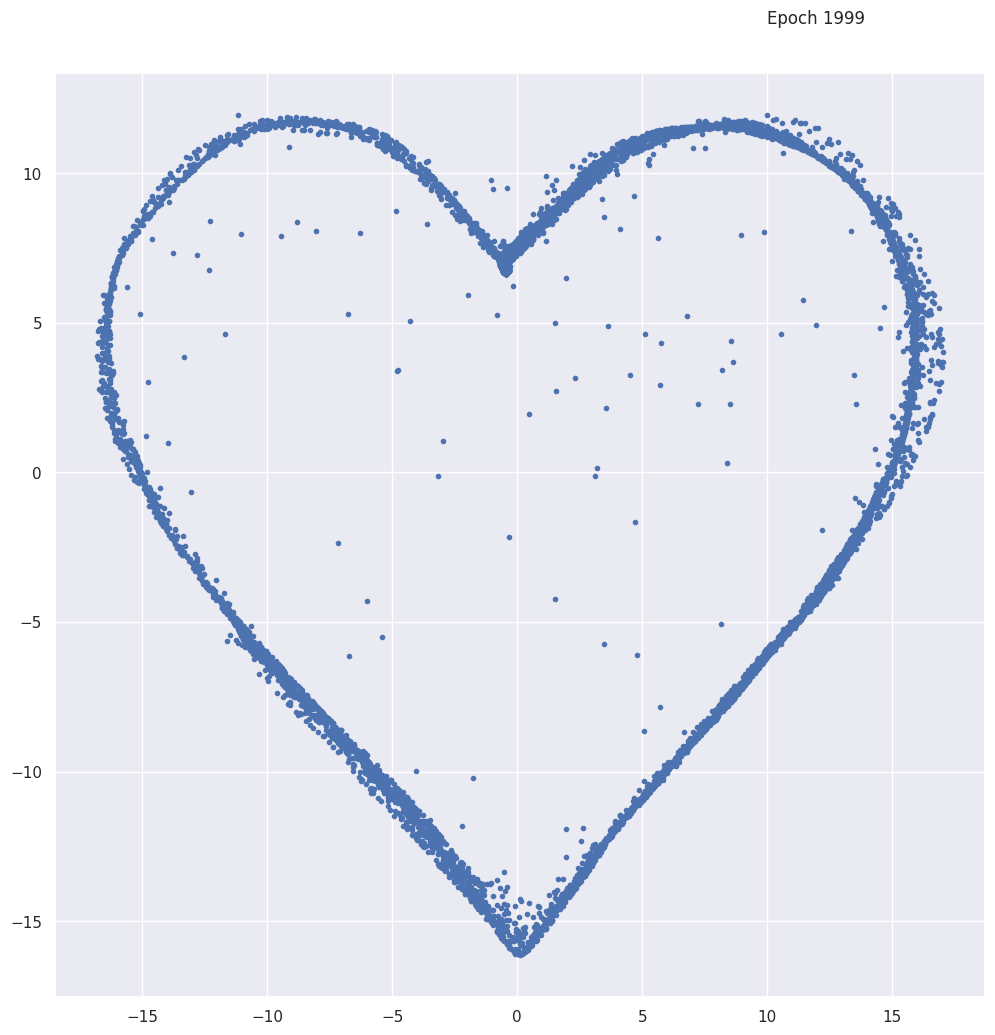

In [33]:

latent_space_samples = torch.randn(10000, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.savefig("plot_image.png")
plt.text(10, 15, f"Epoch {epoch}")

